In [324]:
# Import necessary packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

In [326]:
# Matplotlib Style Settings

plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.unicode_minus'] = False

In [328]:
df = pd.read_csv('./data/macro_processed.csv', index_col='Unnamed: 0')

In [330]:
# Generate lagged values and concatenate to the original dataset.
yX = pd.concat([df.shift(i) for i in range(12)], axis=1).dropna()

In [332]:
# Split dataset into train data and test data.
# No randomness assumed since it is a time series data.
y_train = torch.tensor(yX.iloc[:613, :4].values, dtype=torch.float)
X_train = torch.tensor(yX.iloc[:613, 4:].values, dtype=torch.float)
y_test = torch.tensor(yX.iloc[613:, :4].values, dtype=torch.float)
X_test = torch.tensor(yX.iloc[613:, 4:].values, dtype=torch.float)

In [334]:
print(f'[Train dataset shape] y: {y_train.shape}, X: {X_train.shape}')
print(f'[Test dataset shape]  y: {y_test.shape},  X: {X_test.shape}')

[Train dataset shape] y: torch.Size([613, 4]), X: torch.Size([613, 44])
[Test dataset shape]  y: torch.Size([28, 4]),  X: torch.Size([28, 44])


In [336]:
# Define NVARNN Model.

class VARNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(44, 44)
        self.fc2 = nn.Linear(44, 44)
        self.fc3 = nn.Linear(44, 4)
        
    def forward(self, X):
        X = F.tanh(self.fc1(X))
        X = F.tanh(self.fc2(X))
        X = self.fc3(X)
        
        return X

In [338]:
torch.manual_seed(33)
model = VARNN()

In [340]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [342]:
model

VARNN(
  (fc1): Linear(in_features=44, out_features=44, bias=True)
  (fc2): Linear(in_features=44, out_features=44, bias=True)
  (fc3): Linear(in_features=44, out_features=4, bias=True)
)

In [344]:
# Train the model.

epochs = 100
losses = []

for i in range(epochs):
    
    i += 1
    
    y_pred = model(X_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss.item())
    
    if i%20 == 1:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {loss.item():10.8f}')

epoch:   1 loss: 0.38227025
epoch:  21 loss: 0.34312689
epoch:  41 loss: 0.32583553
epoch:  61 loss: 0.31810325
epoch:  81 loss: 0.31184864
epoch: 100 loss: 0.30480817


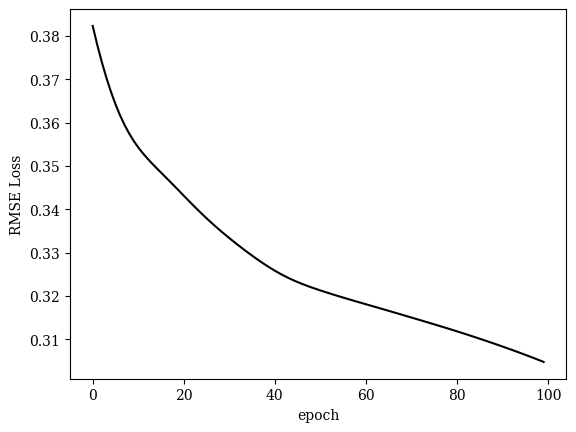

In [346]:
plt.plot(range(epochs), losses, color='k')
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')
plt.show()

In [348]:
with torch.no_grad():
    y_val = model(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
    
print(f'RMSE: {loss:.8f}')

RMSE: 0.13620760


In [350]:
y_forecast = pd.DataFrame(y_val.numpy(), 
                          columns=['ipi_forecast', 'uer_forecast', 'pce_forecast', 'ffr_forecast'], 
                          index=pd.date_range('2022-01-01', '2024-05-01', freq='M'))

y_actual = pd.DataFrame(y_test.numpy(), 
                        columns=['ipi_actual', 'uer_actual', 'pce_actual', 'ffr_actual'], 
                        index=pd.date_range('2022-01-01', '2024-05-01', freq='M'))

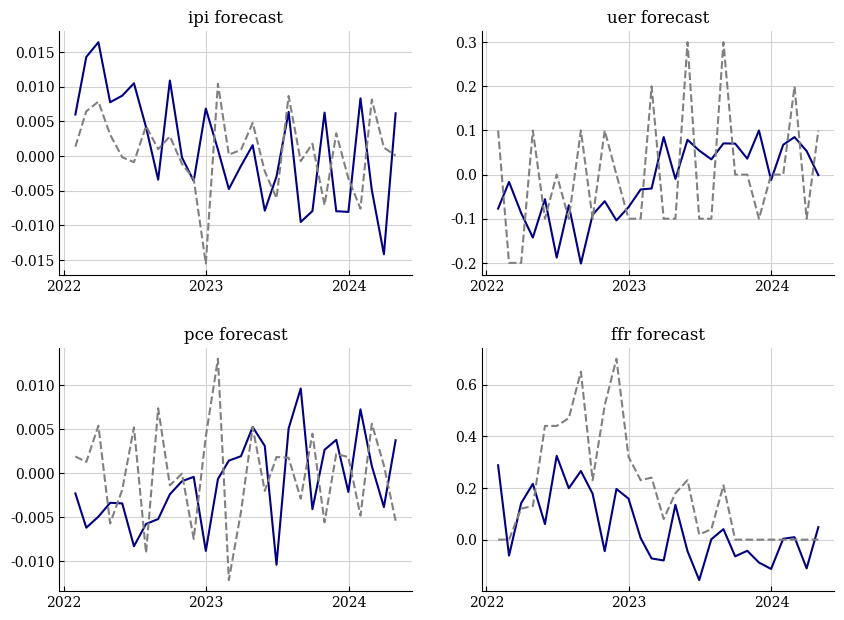

In [380]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs = axs.flatten()

axs[0].plot(y_forecast.ipi_forecast, color='navy')
axs[0].plot(y_actual.ipi_actual, color='gray', ls='--')
axs[0].set_title('ipi forecast')

axs[1].plot(y_forecast.uer_forecast, color='navy')
axs[1].plot(y_actual.uer_actual, color='gray', ls='--')
axs[1].set_title('uer forecast')

axs[2].plot(y_forecast.pce_forecast, color='navy')
axs[2].plot(y_actual.pce_actual, color='gray', ls='--')
axs[2].set_title('pce forecast')

axs[3].plot(y_forecast.ffr_forecast, color='navy')
axs[3].plot(y_actual.ffr_actual, color='gray', ls='--')
axs[3].set_title('ffr forecast')

for ax in axs:
    ax.set_xticks(['2022', '2023', '2024'])
    ax.set_xticklabels(['2022', '2023', '2024'])
    #axs[i].legend()
    ax.grid(color='lightgray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in')

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

In [382]:
fig.savefig('./figures/nn_forecast.png')

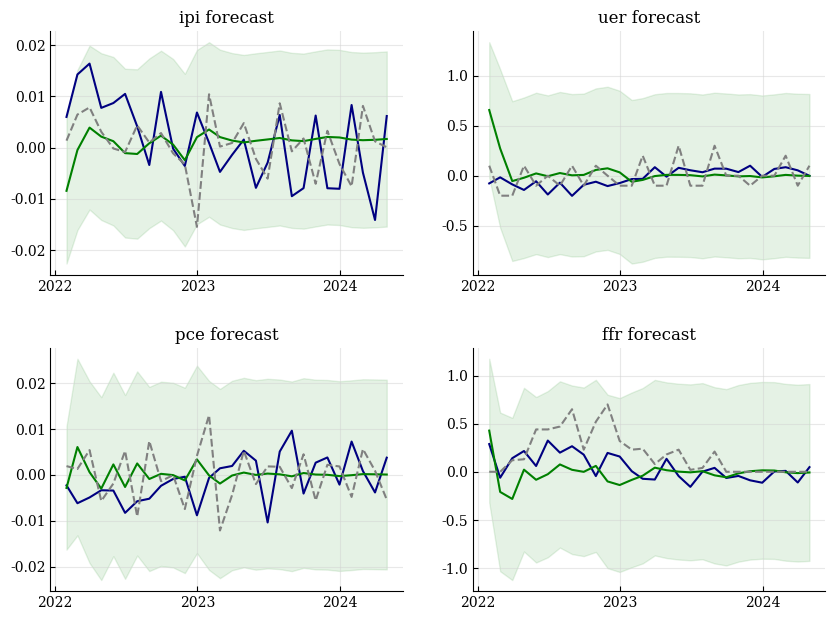

In [385]:
# Plot with VAR forecasts.

var_forecast = pd.read_csv('./data/var_forecasts.csv', index_col='Unnamed: 0')
var_forecast.index = pd.to_datetime(var_forecast.index)
var_ci = pd.read_csv('./data/var_forecasts_ci.csv', index_col='Unnamed: 0')
var_ci.index = pd.to_datetime(var_forecast.index)

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs = axs.flatten()

axs[0].plot(y_forecast.ipi_forecast, color='navy')
axs[0].plot(var_forecast.ipi, color='green')
axs[0].fill_between(var_ci.index, var_ci.ipi_LOWER, var_ci.ipi_UPPER, color='green', alpha=0.1)
axs[0].plot(y_actual.ipi_actual, color='gray', ls='--')
axs[0].set_title('ipi forecast')

axs[1].plot(y_forecast.uer_forecast, color='navy')
axs[1].plot(var_forecast.uer, color='green')
axs[1].fill_between(var_ci.index, var_ci.uer_LOWER, var_ci.uer_UPPER, color='green', alpha=0.1)
axs[1].plot(y_actual.uer_actual, color='gray', ls='--')
axs[1].set_title('uer forecast')

axs[2].plot(y_forecast.pce_forecast, color='navy')
axs[2].plot(var_forecast.pce, color='green')
axs[2].fill_between(var_ci.index, var_ci.pce_LOWER, var_ci.pce_UPPER, color='green', alpha=0.1)
axs[2].plot(y_actual.pce_actual, color='gray', ls='--')
axs[2].set_title('pce forecast')

axs[3].plot(y_forecast.ffr_forecast, color='navy')
axs[3].plot(var_forecast.ffr, color='green')
axs[3].fill_between(var_ci.index, var_ci.ffr_LOWER, var_ci.ffr_UPPER, color='green', alpha=0.1)
axs[3].plot(y_actual.ffr_actual, color='gray', ls='--')
axs[3].set_title('ffr forecast')

for ax in axs:
    ax.set_xticks(['2022', '2023', '2024'])
    ax.set_xticklabels(['2022', '2023', '2024'])
    #axs[i].legend()
    ax.grid(color='lightgray', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in')

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

In [387]:
fig.savefig('./figures/nn_var_forecast.png')

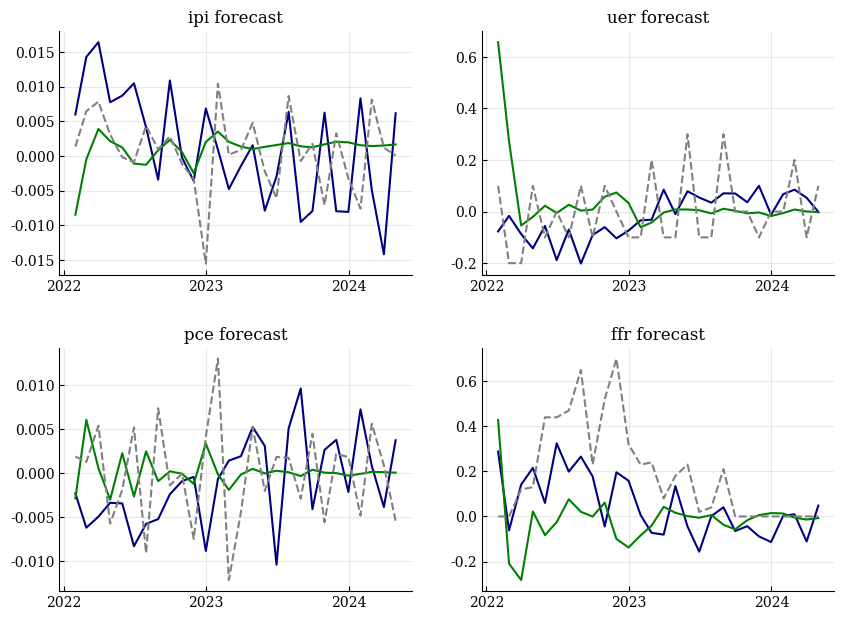

In [376]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs = axs.flatten()

axs[0].plot(y_forecast.ipi_forecast, color='navy')
axs[0].plot(var_forecast.ipi, color='green')
axs[0].plot(y_actual.ipi_actual, color='gray', ls='--')
axs[0].set_title('ipi forecast')

axs[1].plot(y_forecast.uer_forecast, color='navy')
axs[1].plot(var_forecast.uer, color='green')
axs[1].plot(y_actual.uer_actual, color='gray', ls='--')
axs[1].set_title('uer forecast')

axs[2].plot(y_forecast.pce_forecast, color='navy')
axs[2].plot(var_forecast.pce, color='green')
axs[2].plot(y_actual.pce_actual, color='gray', ls='--')
axs[2].set_title('pce forecast')

axs[3].plot(y_forecast.ffr_forecast, color='navy')
axs[3].plot(var_forecast.ffr, color='green')
axs[3].plot(y_actual.ffr_actual, color='gray', ls='--')
axs[3].set_title('ffr forecast')

for ax in axs:
    ax.set_xticks(['2022', '2023', '2024'])
    ax.set_xticklabels(['2022', '2023', '2024'])
    #axs[i].legend()
    ax.grid(color='lightgray', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in')

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

In [378]:
fig.savefig('./figures/nn_var_forecast_without_CI.png')

In [394]:
with torch.no_grad():
    y_inval = model(X_train)

In [403]:
var_fitted = pd.read_csv('./data/var_fittedvalues.csv', index_col='Unnamed: 0')
var_fitted.index = pd.to_datetime(var_fitted.index)

In [409]:
# Compare RMSE values

all_rmse_nn_in = torch.sqrt(criterion(y_inval, y_train))
ipi_rmse_nn_in = torch.sqrt(criterion(y_inval[:, 0], y_train[:, 0]))
uer_rmse_nn_in = torch.sqrt(criterion(y_inval[:, 1], y_train[:, 1]))
pce_rmse_nn_in = torch.sqrt(criterion(y_inval[:, 2], y_train[:, 2]))
ffr_rmse_nn_in = torch.sqrt(criterion(y_inval[:, 3], y_train[:, 3]))

all_rmse_nn_out = torch.sqrt(criterion(y_val, y_test))
ipi_rmse_nn_out = torch.sqrt(criterion(y_val[:, 0], y_test[:, 0]))
uer_rmse_nn_out = torch.sqrt(criterion(y_val[:, 1], y_test[:, 1]))
pce_rmse_nn_out = torch.sqrt(criterion(y_val[:, 2], y_test[:, 2]))
ffr_rmse_nn_out = torch.sqrt(criterion(y_val[:, 3], y_test[:, 3]))

print(f'''
RMSE for MLP
============================
[01] In Sample Results
OVERALL : {all_rmse_nn_in:.8f}
IPI     : {ipi_rmse_nn_in:.8f}
UER     : {uer_rmse_nn_in:.8f}
PCE     : {pce_rmse_nn_in:.8f}
FFR     : {ffr_rmse_nn_in:.8f}
----------------------------
[01] Out-of-Sample Results
OVERALL : {all_rmse_nn_out:.8f}
IPI     : {ipi_rmse_nn_out:.8f}
UER     : {uer_rmse_nn_out:.8f}
PCE     : {pce_rmse_nn_out:.8f}
FFR     : {ffr_rmse_nn_out:.8f}
============================
''')

y_var = torch.tensor(var_forecast.values, dtype=torch.float)
y_invar = torch.tensor(var_fitted.values, dtype=torch.float)

all_rmse_var_in = torch.sqrt(criterion(y_invar, y_train))
ipi_rmse_var_in = torch.sqrt(criterion(y_invar[:, 0], y_train[:, 0]))
uer_rmse_var_in = torch.sqrt(criterion(y_invar[:, 1], y_train[:, 1]))
pce_rmse_var_in = torch.sqrt(criterion(y_invar[:, 2], y_train[:, 2]))
ffr_rmse_var_in = torch.sqrt(criterion(y_invar[:, 3], y_train[:, 3]))

all_rmse_var_out = torch.sqrt(criterion(y_var, y_test))
ipi_rmse_var_out = torch.sqrt(criterion(y_var[:, 0], y_test[:, 0]))
uer_rmse_var_out = torch.sqrt(criterion(y_var[:, 1], y_test[:, 1]))
pce_rmse_var_out = torch.sqrt(criterion(y_var[:, 2], y_test[:, 2]))
ffr_rmse_var_out = torch.sqrt(criterion(y_var[:, 3], y_test[:, 3]))

print(f'''
RMSE for VAR
============================
[01] In Sample Results
OVERALL : {all_rmse_var_in:.8f}
IPI     : {ipi_rmse_var_in:.8f}
UER     : {uer_rmse_var_in:.8f}
PCE     : {pce_rmse_var_in:.8f}
FFR     : {ffr_rmse_var_in:.8f}
----------------------------
[01] Out-of-Sample Results
OVERALL : {all_rmse_var_out:.8f}
IPI     : {ipi_rmse_var_out:.8f}
UER     : {uer_rmse_var_out:.8f}
PCE     : {pce_rmse_var_out:.8f}
FFR     : {ffr_rmse_var_out:.8f}
============================
''')


RMSE for MLP
[01] In Sample Results
OVERALL : 0.30438653
IPI     : 0.01386650
UER     : 0.44404149
PCE     : 0.01219408
FFR     : 0.41604188
----------------------------
[01] Out-of-Sample Results
OVERALL : 0.13620760
IPI     : 0.00915158
UER     : 0.15173891
PCE     : 0.00833136
FFR     : 0.22590303


RMSE for VAR
[01] In Sample Results
OVERALL : 0.29528704
IPI     : 0.00832271
UER     : 0.39698565
PCE     : 0.00786266
FFR     : 0.43709162
----------------------------
[01] Out-of-Sample Results
OVERALL : 0.18572655
IPI     : 0.00576378
UER     : 0.18734252
PCE     : 0.00557834
FFR     : 0.32064912



In [364]:
torch.sqrt(criterion(y_var, y_test))

tensor(0.1857)